In [31]:
import pandas as pd
import sys
from datetime import datetime, timedelta
import time
sys.path.append('..')  # Add the parent directory to the system path
from backend.app.fetch_data_yf import CSV, plot_price_trends, fetch_historical_coin_data
# import pandas_datareader as pdr
import os
import requests


In [5]:
# crypto_data = fetch_historical_coin_data(end_date=datetime(2024, 4, 5), output_file="top_30_cryptos_apr23-apr24.csv")
top_30 =  ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'USDC-USD', 'ADA-USD', 'DOGE-USD', 'TRX-USD', 'STETH-USD', 'PI-USD', 'WBTC-USD', 'LINK-USD', 'HBAR-USD', 'WSTETH-USD', 'LEO-USD', 'AVAX-USD', 'XLM-USD', 'USDS-USD', 'SUI-USD', 'LTC-USD', 'BCH-USD', 'SHIB-USD', 'TON-USD', 'DOT-USD', 'WETH-USD', 'OM-USD', 'BGB-USD', 'USDE-USD']
    
top_30_binance = [coin.replace('-', '')+'T' for coin in top_30]


In [7]:
class Preprocess():
    def __init__(self):
        pass
    
    def save_to_csv(self, df, filename):
        """
        Save the DataFrame to a CSV file
        
        Parameters:
        df (pandas.DataFrame): DataFrame to save
        filename (str): Name of the file to save to
        """
        if df is not None:
            df.to_csv(filename)
            print(f"Data saved to {filename}")
        else:
            print("No data to save")
            
    def missing_values(self, df: pd.DataFrame):
        # First interpolate linearly where possible
        df = df.interpolate(method='time')

        # Then forward-fill any remaining NAs (typically at the beginning of series)
        df = df.fillna(method='ffill')

        # Finally, drop any columns that still have NAs at the beginning
        df = df.dropna(axis=1, how='any')

In [ ]:

class BinanceDataFetcher(Preprocess):
    def __init__(self, data_dir="crypto_data"):
        """
        Initialize the BinanceDataFetcher
        
        Parameters:
        data_dir (str): Directory to save data to
        """
        self.data_dir = data_dir
        
        # Create data directory if it doesn't exist
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
            
        # Binance API base URL
        self.base_url = "https://api.binance.com/api/v3"
        
        # Common trading pairs in Binance
        self.trading_pairs = [
            "BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT",
            "SOLUSDT", "DOTUSDT", "DOGEUSDT", "AVAXUSDT", "MATICUSDT",
            "LINKUSDT", "UNIUSDT", "ATOMUSDT", "LTCUSDT", "BCHUSDT",
            "ALGOUSDT", "XLMUSDT", "FILUSDT", "VETUSDT", "ETCUSDT",
            "THETAUSDT", "TRXUSDT", "MANAUSDT", "AXSUSDT", "FTMUSDT",
            "EGLDUSDT", "NEARUSDT", "XTZUSDT", "ICPUSDT", "CAKEUSDT"
        ]
    
    def get_available_pairs(self):
        """
        Return list of available trading pairs
        
        Returns:
        list: List of available trading pairs
        """
        return self.trading_pairs
    
    def convert_timestamp_to_datetime(self, timestamp):
        """
        Convert timestamp to datetime
        
        Parameters:
        timestamp (int): Timestamp in milliseconds
        
        Returns:
        datetime: Converted datetime
        """
        return datetime.fromtimestamp(timestamp / 1000)
    
    def fetch_klines(self, symbol, interval="1d", start_time=None, end_time=None, limit=1000):
        """
        Fetch klines (candlestick data) for a trading pair
        
        Parameters:
        symbol (str): Trading pair symbol (e.g., 'BTCUSDT')
        interval (str): Kline interval (1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M)
        start_time (int): Start time in milliseconds
        end_time (int): End time in milliseconds
        limit (int): Maximum number of klines to return (max 1000)
        
        Returns:
        list: List of klines
        """
        url = f"{self.base_url}/klines"
        
        params = {
            "symbol": symbol,
            "interval": interval,
            "limit": limit
        }
        
        if start_time:
            params["startTime"] = start_time
        
        if end_time:
            params["endTime"] = end_time
        
        try:
            response = requests.get(url, params=params)
            
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error: API request failed with status code {response.status_code}")
                print(f"Response: {response.text}")
                return None
        
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
    
    def fetch_historical_data(self, symbol, years=5, interval="1d"):
        """
        Fetch historical data for a trading pair over multiple years
        
        Parameters:
        symbol (str): Trading pair symbol (e.g., 'BTCUSDT')
        years (int): Number of years of data to fetch
        interval (str): Kline interval
        
        Returns:
        pandas.DataFrame: DataFrame containing OHLC data
        """
        print(f"Fetching {years} years of {interval} data for {symbol}...")
        
        # Calculate start and end times
        end_time = int(datetime.now().timestamp() * 1000)
        start_time = int((datetime.now() - timedelta(days=years*365)).timestamp() * 1000)
        
        all_klines = []
        current_start_time = start_time
        
        # Binance API can return max 1000 candles per request, so we need to make multiple requests
        while current_start_time < end_time:
            klines = self.fetch_klines(
                symbol=symbol,
                interval=interval,
                start_time=current_start_time,
                limit=1000
            )
            
            if not klines or len(klines) == 0:
                break
            
            all_klines.extend(klines)
            
            # Update start time for next request
            # The last candle's open time + 1
            current_start_time = klines[-1][0] + 1
            
            # Respect API rate limits
            time.sleep(0.5)
            
            print(f"Fetched {len(klines)} candles. Total: {len(all_klines)}")
        
        if not all_klines:
            print("No data fetched")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(all_klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        
        # Convert string values to float for price and volume data
        numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                          'quote_asset_volume', 'taker_buy_base_asset_volume', 
                          'taker_buy_quote_asset_volume']
        
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col])
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        # Set timestamp as index
        df.set_index('timestamp', inplace=True)
        
        # Add symbol column
        df['symbol'] = symbol
        
        # Extract just OHLC
        df = df[['symbol', 'open', 'high', 'low', 'close', 'volume']]
        
        print(f"Successfully fetched {len(df)} data points for {symbol}")
        return df
    
    def fetch_multiple_pairs(self, symbols=None, years=5, interval="1d"):
        """
        Fetch historical data for multiple trading pairs
        
        Parameters:
        symbols (list): List of trading pair symbols (e.g., ['BTCUSDT', 'ETHUSDT'])
        years (int): Number of years of data to fetch
        interval (str): Kline interval
        
        Returns:
        dict: Dictionary of DataFrames containing OHLC data for each trading pair
        """
        if symbols is None:
            symbols = self.trading_pairs[:5]  # Default to first 5 pairs if none specified
        
        data = {}
        
        for symbol in symbols:
            df = self.fetch_historical_data(symbol, years, interval)
            
            if df is not None:
                data[symbol] = df
                
                # Save individual data to CSV
                csv_filename = f"{self.data_dir}/{symbol.lower()}_{interval}.csv"
                self.save_to_csv(df, csv_filename)
                
                # Respect API rate limits between different symbols
                time.sleep(1)
        
        return data

# Initialize the fetcher
# fetcher = BinanceDataFetcher()

# Fetch BTC/USDT data for 5 years
# btc_data = fetcher.fetch_historical_data("BTCUSDT")

# fetcher.save_to_csv(btc_data, "../backend/data/BTC-past-5y-ohlc.csv")



In [11]:
try:
    data = pd.read_csv(CSV, sep=',', encoding='utf8', index_col=0, parse_dates=True)
    print(data.head(3).to_markdown())
except Exception as e:
    print(f"Error loading data: {e}")


| Date                |   ADA-USD |   AVAX-USD |   BCH-USD |   BNB-USD |   BTC-USD |   DOGE-USD |   DOT-USD |   ETH-USD |   HBAR-USD |   LEO-USD |   LINK-USD |   LTC-USD |   OM-USD |   PI-USD |   SHIB-USD |   SOL-USD |   STETH-USD |   TON-USD |   TRX-USD |   USDC-USD |   USDT-USD |   WBTC-USD |   WETH-USD |   WSTETH-USD |   XLM-USD |   XRP-USD |
|:--------------------|----------:|-----------:|----------:|----------:|----------:|-----------:|----------:|----------:|-----------:|----------:|-----------:|----------:|---------:|---------:|-----------:|----------:|------------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|-------------:|----------:|----------:|
| 2024-03-06 00:00:00 |  0.733821 |    41.5143 |   415.128 |   429.012 |   66106.8 |   0.157791 |   10.5142 |   3819.23 |   0.125818 |   5.48234 |    20.076  |   85.83   | 0.312082 | 0.005099 |    3.3e-05 |   130.742 |     3819.76 |   2.88386 |  0.137763 |   0.999801 |    1.00045 |    66224.6 |    3821.

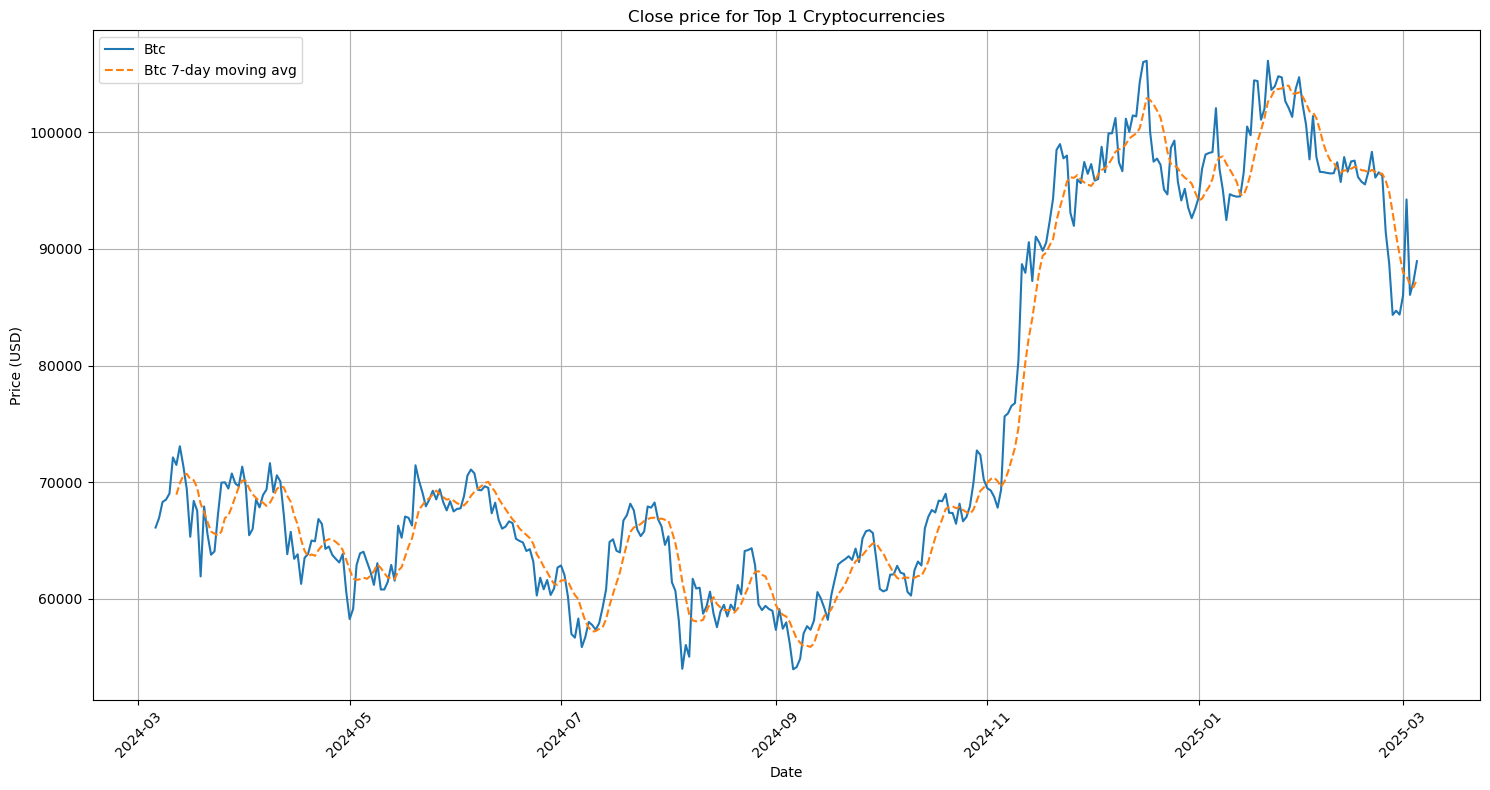

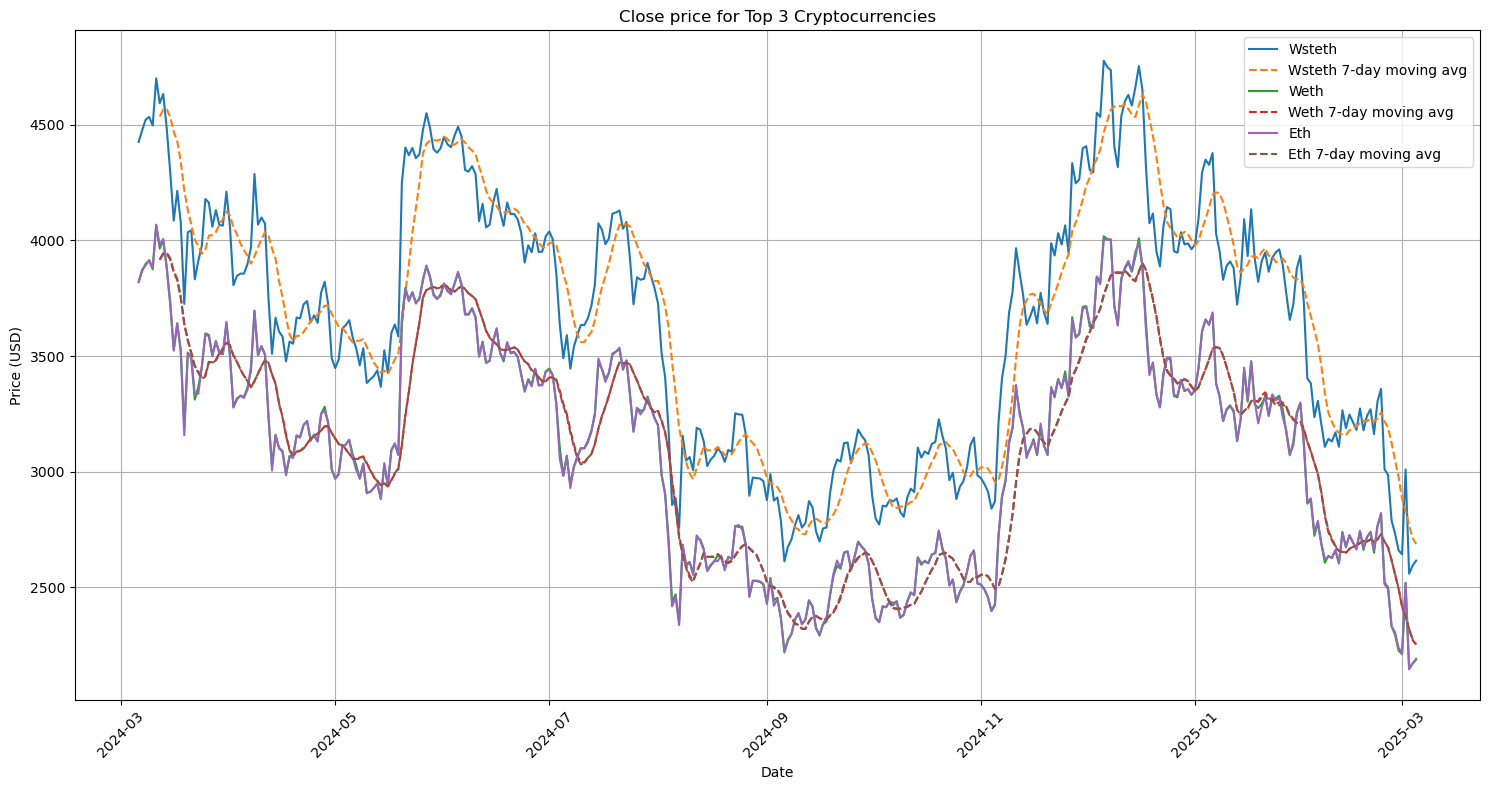

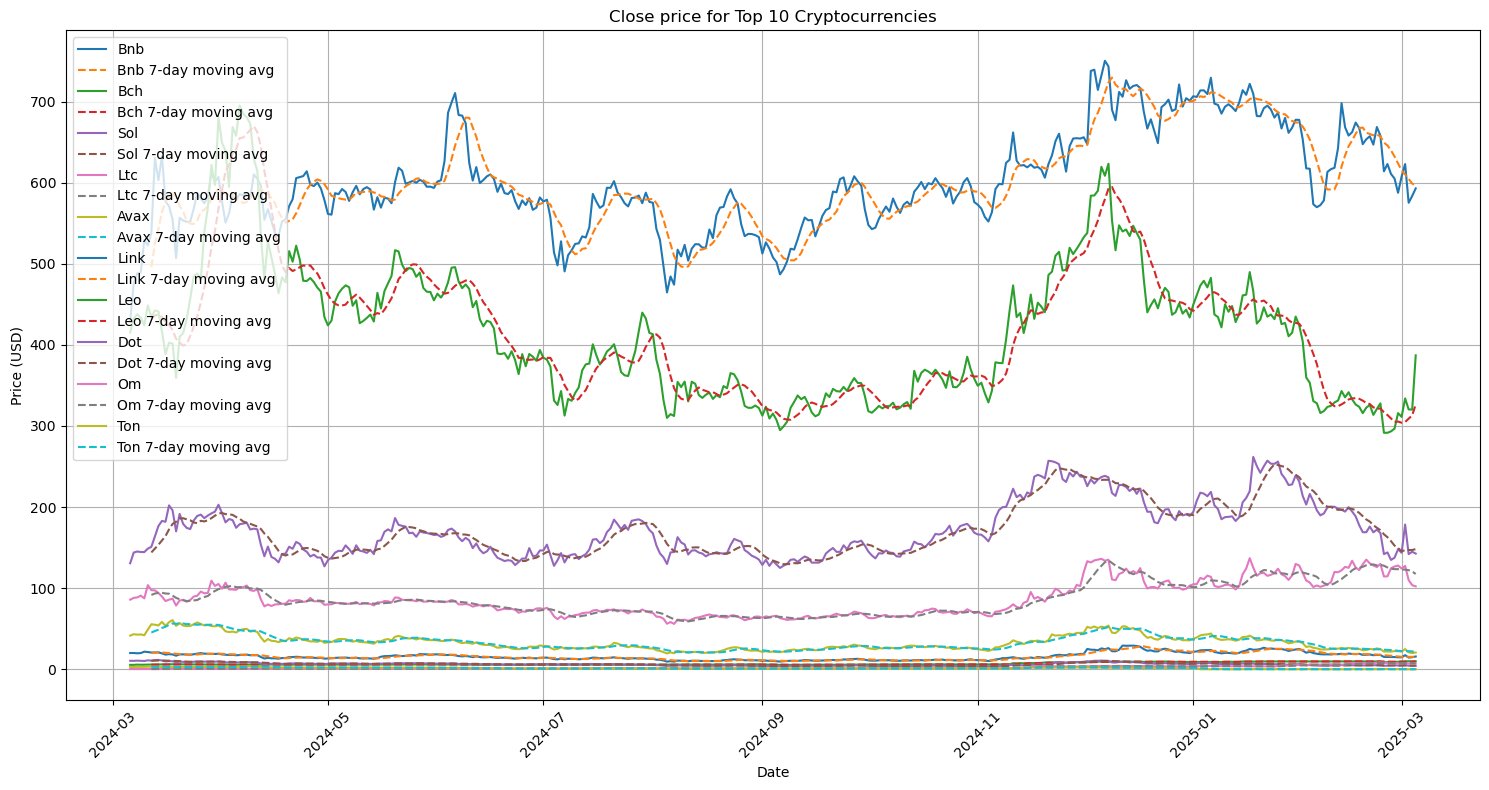

In [12]:
# data.mean().to_list()
btc = data.loc[:,'BTC-USD'].to_frame()
plot_price_trends(btc, 1)
plot_price_trends(data.drop(['BTC-USD', 'WBTC-USD'], axis=1), 3)
plot_price_trends(data.drop(['BTC-USD', 'WBTC-USD', 'WSTETH-USD', 'WETH-USD', 'ETH-USD', 'STETH-USD'], axis=1), 10)

## for coins 'BNB-USD', 'BTC-USD', 'WETH-USD'

### BNB

high negative ADF (less than 1%) with a very low P value.

suggesting a high probability that the coin is stationary over the past year.


### BTC

looking at the plot over the past year clearly shows this is non-stationary...

the ADF is close to zero with a high P value, confirming it is non-stationary.

### WETH

negative ADF (higher than 10% indicating low confidence) with a high P value.

suggesting this coin is also non-stationary. Less so, however than a coin like BTC.

In [13]:
# Create a feature matrix where each row is a cryptocurrency
# and each column is a day (transpose the data)
price_features = data.T

# Replace any remaining NaN values with 0
price_features = price_features.fillna(0)

print(f"Each row represents a cryptocurrency, each column a day's price")
print(price_features.index)
print(price_features.head(3).to_markdown())
print(f"Feature matrix shape: {price_features.shape}")

Each row represents a cryptocurrency, each column a day's price
Index(['ADA-USD', 'AVAX-USD', 'BCH-USD', 'BNB-USD', 'BTC-USD', 'DOGE-USD',
       'DOT-USD', 'ETH-USD', 'HBAR-USD', 'LEO-USD', 'LINK-USD', 'LTC-USD',
       'OM-USD', 'PI-USD', 'SHIB-USD', 'SOL-USD', 'STETH-USD', 'TON-USD',
       'TRX-USD', 'USDC-USD', 'USDT-USD', 'WBTC-USD', 'WETH-USD', 'WSTETH-USD',
       'XLM-USD', 'XRP-USD'],
      dtype='object')
|          |   2024-03-06 00:00:00 |   2024-03-07 00:00:00 |   2024-03-08 00:00:00 |   2024-03-09 00:00:00 |   2024-03-10 00:00:00 |   2024-03-11 00:00:00 |   2024-03-12 00:00:00 |   2024-03-13 00:00:00 |   2024-03-14 00:00:00 |   2024-03-15 00:00:00 |   2024-03-16 00:00:00 |   2024-03-17 00:00:00 |   2024-03-18 00:00:00 |   2024-03-19 00:00:00 |   2024-03-20 00:00:00 |   2024-03-21 00:00:00 |   2024-03-22 00:00:00 |   2024-03-23 00:00:00 |   2024-03-24 00:00:00 |   2024-03-25 00:00:00 |   2024-03-26 00:00:00 |   2024-03-27 00:00:00 |   2024-03-28 00:00:00 |   2024-03-29 00

In [14]:
# Import additional required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

rows of data:  26
optimal_components=2
Reduced dimensions from 365 to 2
Total variance explained: 100.00%
returning PCA with 2 components
|          |      PC1 |        PC2 |
|:---------|---------:|-----------:|
| ADA-USD  | -6.09755 | -0.110223  |
| AVAX-USD | -6.06535 | -0.103891  |
| BCH-USD  | -5.68375 | -0.0359162 |


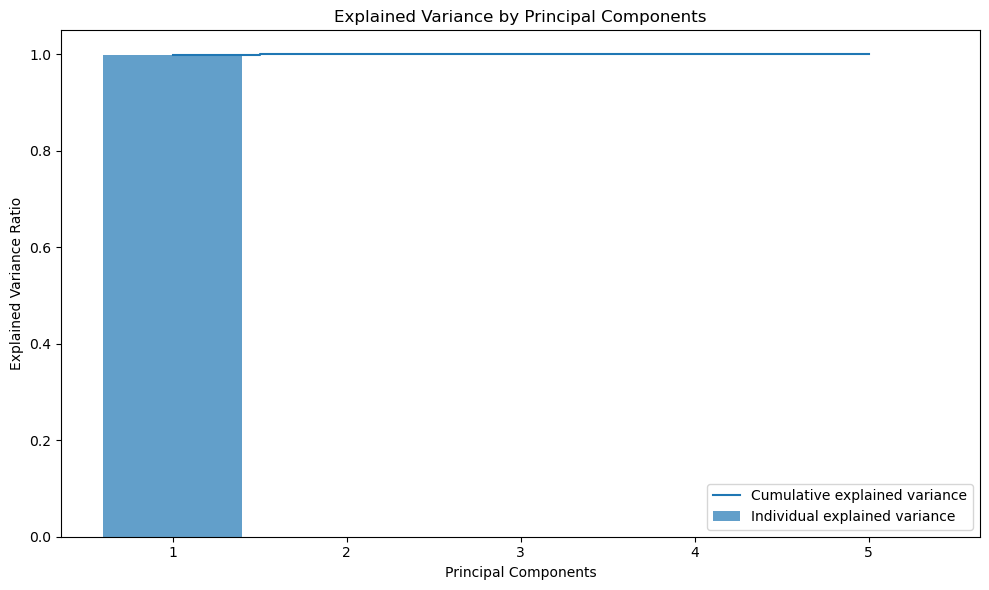

In [15]:
def reduce_dimensions(features: pd.DataFrame, n_components=10, optimise=False):
    """
    Perform dimensionality reduction on cryptocurrency data using PCA
    
    Args:
        features (pandas.DataFrame): Feature matrix (cryptocurrencies as rows)
        n_components (int): Number of components to reduce to
        
    Returns:
        DataFrame with reduced dimensions, PCA model
    """
    # Standardize the data
    print("rows of data: ", features.shape[0])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    optimal_components = sum(np.less_equal(cumulative_variance, np.full(len(cumulative_variance), 0.99)))
    if not optimal_components:
        # the cumulative variance is higher than the desired threshold from the first component
        optimal_components = 2
    print(f"{optimal_components=}")
    if not optimise:
        optimal_components=n_components
    
    print(f"Reduced dimensions from {features.shape[1]} to {optimal_components}")
    print(f"Total variance explained: {cumulative_variance[2]:.2%}")
    print(f'returning PCA with {optimal_components} components')
    pca = PCA(n_components=optimal_components)
    pca.fit_transform(scaled_features)
    
    # Apply PCA
    pca = PCA(n_components=optimal_components)
    reduced_features = pca.fit_transform(scaled_features)
    
    # Create DataFrame with reduced features
    reduced_df = pd.DataFrame(
        reduced_features, 
        index=features.index,
        columns=[f'PC{i+1}' for i in range(optimal_components)]
    )

    print(reduced_df.head(3).to_markdown())
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components+1), explained_variance, alpha=0.7, label='Individual explained variance')
    plt.step(range(1, n_components+1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.xticks(np.arange(1, n_components+1, 1))
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return reduced_df, pca

# Reduce dimensions to 10 principal components
reduced_features, pca_model = reduce_dimensions(price_features, n_components=5, optimise=True)

## are the values, magnitude and variance of BTC causing the explained variance to be consumed by a single component?

### in other words, is BTC causing some sort of bias or skewness?

experiment with PCA on all other rows besides BTC

rows of data:  25
optimal_components=2
Reduced dimensions from 365 to 5
Total variance explained: 100.00%
returning PCA with 5 components
|          |      PC1 |        PC2 |          PC3 |         PC4 |          PC5 |
|:---------|---------:|-----------:|-------------:|------------:|-------------:|
| ADA-USD  | -4.69057 | -0.148798  | -0.00529639  | -0.00203875 | -0.000381796 |
| AVAX-USD | -4.64686 | -0.140231  | -0.000891487 | -0.00584526 | -0.000490875 |
| BCH-USD  | -4.12873 | -0.0484595 |  0.073794    | -0.0152251  |  0.000706165 |


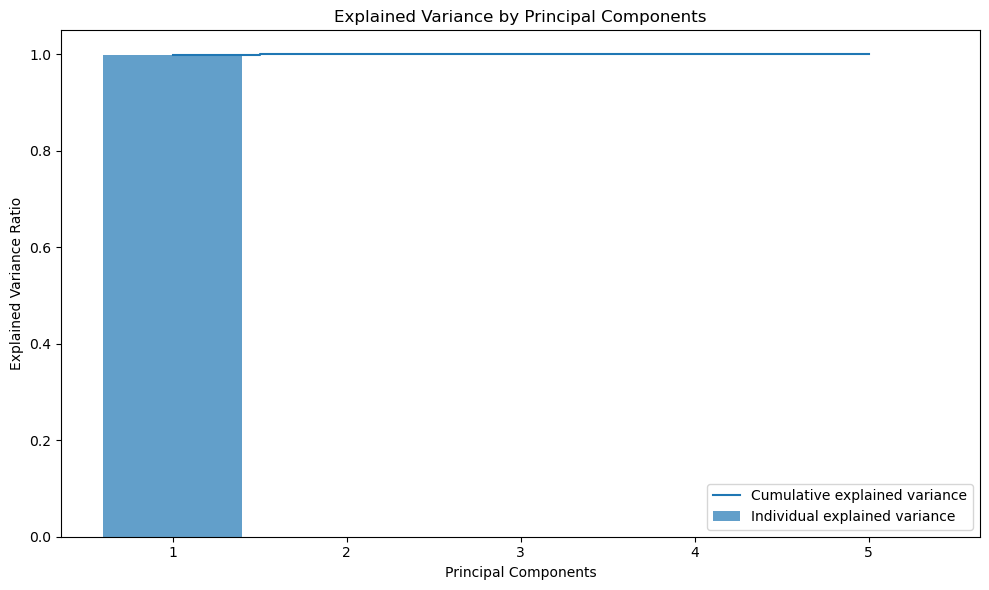

optimal components with BTC in the dataset 2.
 Optimal components without BTC in the dataset 5


In [16]:
features_no_btc = price_features.drop('BTC-USD', axis=0)

# Reduce dimensions to 5 principal components
reduced_features_wo_btc, pca_model_wo_btc = reduce_dimensions(features_no_btc, n_components=5)

print((f'optimal components with BTC in the dataset {pca_model.n_components_}.\n'),
      (f'Optimal components without BTC in the dataset {pca_model_wo_btc.n_components_}'))

# Determine optimal number of clusters

optimal_clusters=2


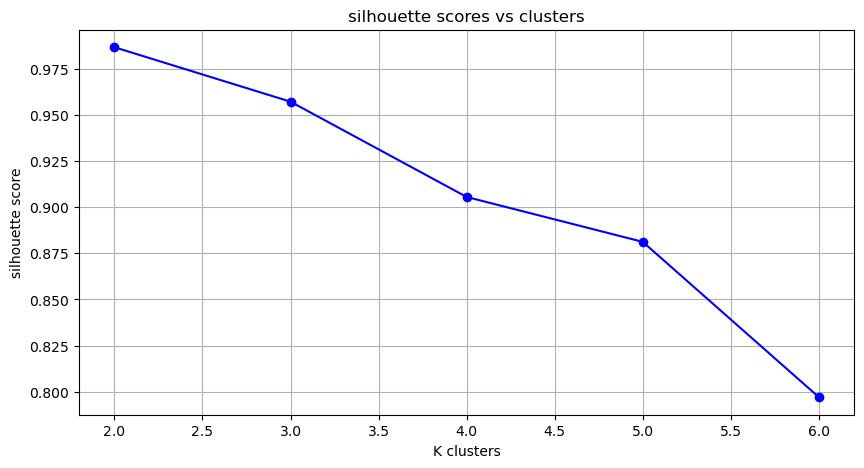

returning model with n_clusters=4
|          |      PC1 |        PC2 |   cluster |
|:---------|---------:|-----------:|----------:|
| ADA-USD  | -6.09755 | -0.110223  |         0 |
| AVAX-USD | -6.06535 | -0.103891  |         0 |
| BCH-USD  | -5.68375 | -0.0359162 |         3 |


In [17]:
def clustering_cryptos(price_features_df: pd.DataFrame, n_clusters=4):
    """
    Cluster cryptocurrencies based on reduced features
    
    Args:
        features (pandas.DataFrame): Reduced feature matrix
        n_clusters (int): Number of clusters to create
        
    Returns:
        DataFrame with cluster assignments, KMeans model
    """
    # if n_clusters is None
    silhouette_scores = []
    # Perform silhouette from 2 to 6 K clusters
    K = range(2,7)
    for k in K:
        kmeans = KMeans(n_clusters=k).fit(price_features_df)
        silhouette_scores.append(
            silhouette_score(price_features_df, kmeans.labels_)
        )
    # get the optimal number of clusters
    optimal_clusters = K[np.argmax((silhouette_scores))]
    print(f"{optimal_clusters=}")
    # Plot silhouetter scores
    plt.figure(figsize=(10,5))
    plt.plot(K, silhouette_scores, 'bo-')
    plt.grid(True)
    plt.ylabel("silhouette score")
    plt.xlabel("K clusters")
    plt.title("silhouette scores vs clusters")
    plt.show()
    
    if n_clusters is None:
        n_clusters = optimal_clusters
    # train the final kemans model
    print(f"returning model with {n_clusters=}")
    kmeans = KMeans(n_clusters=n_clusters).fit(price_features_df)
    # copy the dataset
    clustered_df = price_features_df.copy()
    # add a column for the kmeans with the kmeans cluster labels (output of fit function)
    clustered_df['cluster'] = kmeans.labels_
    print(clustered_df.head(3).to_markdown())
    # return the dataframe and kmeans model
    return clustered_df, kmeans
    
clustered_df, kmeans_model = clustering_cryptos(price_features_df=reduced_features, n_clusters=4)
    

## plot the clusters in 2D space

In [18]:
import plotly.express as px

def visualise_clusters(clustered_df:pd.DataFrame):
    """
    Place clusters on a scatter plot
    If required, reduce dimensionality to 2 using t-SNE
    
    Args:
        clustered_df (pd.DataFrame) : price features, with output labels.
        
    """
    # take a copy of the df
    vis_df = clustered_df.copy()
    x_label = "PCA component 1"
    y_label = "PCA component 2"
    # if dimensions greater than two
    if vis_df.drop('cluster', axis=1).shape[1] > 2:
        # drop the cluster colun and perform t-SNE dimensionality reduction for the plot
        vis_tsne = TSNE(n_components=2, random_state=42, perplexity=6)
        x_tsne = vis_tsne.fit_transform(clustered_df.drop('cluster', axis=1))
        x_label = "t-SNE dimension 1"
        y_label = "t-SNE dimension 2"
        fig = px.scatter(x=x_tsne[:,0], y=x_tsne[:,1], color=vis_df.index)
        print("reduced visualisation dimensions to 2, using TSNE\nKL Divergence: ", vis_tsne.kl_divergence_)
    
    # create a dataframe of the new dimensions - this will be plotted
    fig = px.scatter(vis_df,
                     x='PC1',
                     y="PC2",
                     hover_data='cluster',
                     color=vis_df.index,
                     width=1100,
                     height=700
                     )
    # create the plotly scatter
    # create the plot
    fig.update_layout(
        title=dict(text='Cryptocurrency Clusters Visualization'),
        xaxis_title=x_label,
        yaxis_title=y_label
    ) 
    """{
        'title': {'text':'Cryptocurrency Clusters Visualization'},
        'xaxis': {'text': x_label},
        'yaxis': {'text': y_label},
    }"""
    # set the x and y ticks to the df index i.e coin names
    fig.show()
    
visualise_clusters(clustered_df)
    
    
    

In [19]:
# stationarity analysis
from statsmodels.tsa.stattools import adfuller
from IPython.display import Markdown, display

selected_coins = ['BNB-USD', 'BTC-USD', 'ETH-USD', "LTC-USD"]

def get_adf_stats(selected_coins: list, coin_data: pd.DataFrame):
    adf_coins = []
    p_val_coins = []
    five_pct_stat = []
    one_pct_stat = []
    ten_pct_stat = []
    stationary_hypothesis = []
    
    for coin in selected_coins:
        x = coin_data.loc[:,coin].values
        stationary_stats = adfuller(x)
        # results[coin] = dict(adf=stationary_stats[0],
        #                     p_value=stationary_stats[1],
        #                     critical_values=stationary_stats[4])
        adf_coins.append(stationary_stats[0])
        p_val_coins.append(stationary_stats[1])
        one_pct_stat.append(stationary_stats[4]["1%"])
        five_pct_stat.append(stationary_stats[4]["5%"])
        ten_pct_stat.append(stationary_stats[4]["10%"])
        
        if stationary_stats[1] > 0.05:
            stationary_hypothesis.append(False)
        elif stationary_stats[0] < -1 and stationary_stats[0] > stationary_stats[4]["10%"]:
            stationary_hypothesis.append(False)
        else:
            stationary_hypothesis.append(True)
    
    results = pd.DataFrame(
        {
            "ADF": adf_coins,
            "P_Value": p_val_coins,
            "1%": one_pct_stat,
            "5%": five_pct_stat,
            "10%": ten_pct_stat,
            "Stationary": stationary_hypothesis
        },
        index=selected_coins
    )
    
    # for k,v in result.items():
    #     print(f"{k} : {v}")
    return results

ads_stats = get_adf_stats(selected_coins, data)

print(ads_stats.to_markdown())

def display_markdown(stats: dict):
    table = "|"
    ruler = "|"
    tmp = len(table)
    table += "Coin |"
    ruler += "-" * (len(table) - tmp - 1) + "|"

    for k in ads_stats[selected_coins[0]].keys():
        if isinstance(ads_stats[selected_coins[0]][k], dict):
            for sub_k in ads_stats[selected_coins[0]][k]:
                tmp = len(table)
                table += f" {sub_k} |"
                ruler += "-" * (len(table) - tmp - 1) + "|"
        else:
            tmp = len(table)
            table += f" {k} |"
            ruler += "-" * (len(table) - tmp - 1) + "|"
    table += "\n"
    ruler += "\n"
    table += ruler
    table += "|"
    for coin, ads_stat in ads_stats.items():
        tmp = len(table)
        table += f"{coin} |"
        for v in ads_stat.values():
            if isinstance(v, dict):
                for sub_v in v.values():
                    table += f" {sub_v} |"
            else:
                table += f" {v} |"
        table += "\n"

    display(Markdown(table))

|         |      ADF |    P_Value |       1% |       5% |      10% | Stationary   |
|:--------|---------:|-----------:|---------:|---------:|---------:|:-------------|
| BNB-USD | -3.67848 | 0.00442625 | -3.44844 | -2.86951 | -2.57102 | True         |
| BTC-USD | -1.1333  | 0.701611   | -3.44844 | -2.86951 | -2.57102 | False        |
| ETH-USD | -2.05408 | 0.263377   | -3.44844 | -2.86951 | -2.57102 | False        |
| LTC-USD | -1.96639 | 0.301503   | -3.44844 | -2.86951 | -2.57102 | False        |


## Analyse correlations

In [20]:
def analyse_correlations(data, crypto_cluster_representatives):
    """
    Analyse correlations between selected coins and all cryptos in the dataset
    
    Args
        data (pandas.DataFrame): dataset of all coins and their closing prices
        crypto_cluster_representatives (list):
                                 list of selected coins
    Returns
        DataFrame: Correlation matrix
    """
    # get column names for representatives - should match but best to extract from the dataset
    representative_col_names = [col for col in data.columns if any(rep.lower() == col.lower() for rep in crypto_cluster_representatives)]
    print("representative coins found in dataset:\n",representative_col_names)
    # calculate the correlation matrix for the entire close dataset
    corr_matrix = data.corr()
    # extract the correlations for the selected coins
    representatives_correlation_matrix = corr_matrix[representative_col_names]
    # plot correlation heatmap
    fig = px.imshow(
        representatives_correlation_matrix,
        labels=dict(color="correlation"),
        color_continuous_scale="Inferno_r",
        text_auto=True,
        aspect='auto',
        height=1000,
    )
    fig.update_xaxes(side='top')
    fig.show()
    return representatives_correlation_matrix
# use the scatter plot in the above cell to pick a coin from each cluster group.

selected_coin_corr = analyse_correlations(data, selected_coins)

representative coins found in dataset:
 ['BNB-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']


# Find correlation extremes


In [21]:
def get_corr_extremes(corr_matrix: pd.DataFrame, num_pos_neg_coins=4):
    
    results = {}
    results2 = {}
    
    # iterate through each column in the matrix
    for repr_col in corr_matrix.columns:
        # get the correlation for this column, dropping the self-corr column
        representative_corr = corr_matrix[repr_col].drop(repr_col)
        # get the list of the top 4 positive correlations
        top_positives: pd.Series = representative_corr.nlargest(num_pos_neg_coins)
        # get the list of the top 4 negative correlations
        top_negatives: pd.Series = representative_corr.nsmallest(num_pos_neg_coins)
        # add to dict, a dict of the postive and negative corrs for a given column (coin)
        repr_name = repr_col.split('-')[0]
        results[repr_name] = {
            'positive': [(col.split('-')[0], corr) for col, corr in top_positives.items()],
            'negative': [(col.split('-')[0], corr) for col, corr in top_negatives.items()]
        }
        results2[repr_col] = pd.DataFrame(
            {str(repr_col): pd.concat([top_positives, top_negatives])}
        )
        # print(repr_col)
        # print("top pos: ", top_positives.items())
        # print("top neg: ", top_negatives)
    # return the dict
    return results2

top_pos_neg = get_corr_extremes(selected_coin_corr, 4)

# postive_title = "%s - top positively correlated coins:"
# negative_title = "%s - top negatively correlated coins:"
# for coin, data in top_pos_neg.items():
#     print(postive_title % coin)
#     print("-" * len(postive_title))
#     for corr_pos_coin, corr in data['positive']:
#         print(f"\t{corr_pos_coin} - Correlation: {corr}")
#     print(negative_title % coin)
#     print("-" * len(negative_title))
#     for corr_neg_coin, corr in data['negative']:
#         print(f"\t{corr_neg_coin} - Correlation: {corr}")

title_str = "Top positive and negative correlated coins:"
print(title_str)
print("-" * len(title_str))
sep_len = len(title_str)
for coin, df in top_pos_neg.items():
    print(top_pos_neg[coin].T.to_markdown())
    print()


Top positive and negative correlated coins:
-------------------------------------------
|         |   BTC-USD |   WBTC-USD |   DOGE-USD |   HBAR-USD |    PI-USD |   TON-USD |   USDT-USD |    USDC-USD |
|:--------|----------:|-----------:|-----------:|-----------:|----------:|----------:|-----------:|------------:|
| BNB-USD |   0.82948 |   0.829018 |   0.806936 |   0.786174 | -0.193981 | -0.159604 | -0.0985299 | -0.00642017 |

|         |   WBTC-USD |   LEO-USD |   DOGE-USD |   XLM-USD |   TON-USD |    PI-USD |   USDC-USD |   USDT-USD |
|:--------|-----------:|----------:|-----------:|----------:|----------:|----------:|-----------:|-----------:|
| BTC-USD |   0.999971 |  0.954715 |   0.931514 |  0.930809 | -0.297925 | -0.201206 | -0.0540657 |  0.0495566 |

|         |   STETH-USD |   WETH-USD |   WSTETH-USD |   DOT-USD |    OM-USD |   TRX-USD |   USDC-USD |   USDT-USD |
|:--------|------------:|-----------:|-------------:|----------:|----------:|----------:|-----------:|-----------:|


## time-series decomposition

In [22]:
# five_yr_coin_df = fetch_historical_coin_data(period='5y', output_file="5_yr_top_30_cryptos.csv")


In [23]:
from pycaret.time_series import *

experiment = setup(data.loc[:,'BTC-USD'], session_id=1)

,Description,Value
0,session_id,1
1,Target,BTC-USD
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(365, 1)"
5,Transformed data shape,"(365, 1)"
6,Transformed train set shape,"(364, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [24]:
experiment.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,365.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,74675.750214
3,Summary,Statistics,Transformed,Median,,67811.507812
4,Summary,Statistics,Transformed,Standard Deviation,,15696.710823
5,Summary,Statistics,Transformed,Variance,,246386730.671094
6,Summary,Statistics,Transformed,Kurtosis,,-1.137579
7,Summary,Statistics,Transformed,Skewness,,0.703557
8,Summary,Statistics,Transformed,# Distinct Values,,365.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",7354.395096


In [25]:
experiment.plot_model(plot='decomp')
experiment.plot_model(plot='decomp', data_kwargs = {'type' : 'multiplicative'})

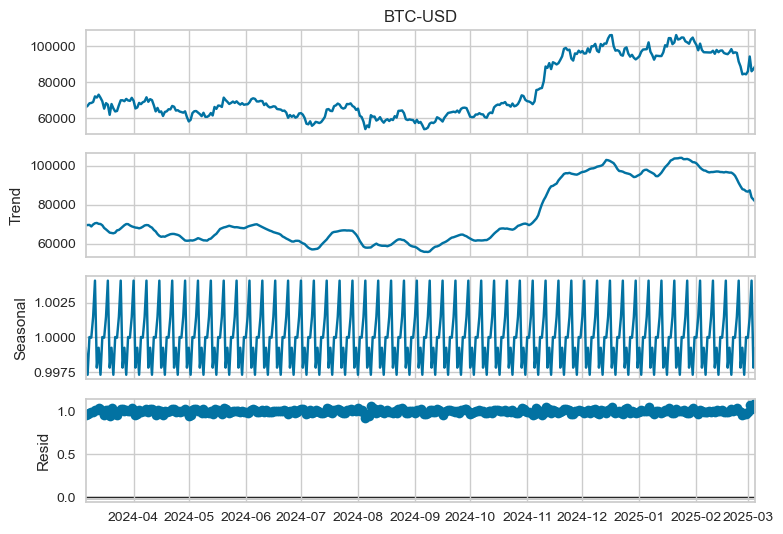

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(data.loc[:,'BTC-USD'], model='multiplicative', extrapolate_trend='freq')

decompose.plot().show()

In [27]:
experiment.plot_model(plot='pacf')
experiment.plot_model(plot='acf')

In [28]:
# TODO explain the above partial and long term autocorrelation
# TODO explain why one tool shows seasonality and another doesn't
""" the second plot with seasonality might be red herring due to the high frequency
and subtle change in value being interpreted as a repeating pattern over short time
intervals"""


' the second plot with seasonality might be red herring due to the high frequency\nand subtle change in value being interpreted as a repeating pattern over short time\nintervals'

# Repeat time series decomposition

## for other three selected coins

In [29]:
# repeat time series decomp for other selected coins.
final_coins = [coin.replace('-', '')+'T' for coin in selected_coins]

# obtain 5 yr data for each coin



In [30]:
# TODO visualise the distribution of BTC, repeat for other selected coins.
# TODO visualise the change in distribution over intervals
# e.g looking at the line plots a 6 month interval might be good starting point.

# TODO complete temporal analysis (check your notes for this)